### Modelos de Aprendizaje Automático - Exploración al tanteo

En este notebook, exploramos diferentes modelos de Machine Learning y objetivos de clasificación de condiciones de arbitraje para diferentes bases de datos de rezagos en los precios. Realizamos algunas observaciones preliminares con base en una primera aproximación a los datos. Definimos varios targets y rezagos para la clasificación, definimos un modelo base sobre el cual se establecen métricas de desempeño como punto de referencia. Observamos la incidencia de las variables categóricas, la selección de features yel número de lags en las métricas de desempeño.

### Definiciones

In [1]:
#Imports
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from xgboost import XGBClassifier 
from sklearn.model_selection import cross_val_score, RepeatedKFold,RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt # Matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import operator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearnex import patch_sklearn
patch_sklearn()
#from Funciones import *

%matplotlib inline


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# Funcion para calcular y visualizar la matriz de confusion con valores normalizados
def plotCM(ytrue, ypred, clases=None, normalize = False, ax = None):
    """ Funcion para calcular y visualizar la matriz de confusion"""
    
    if clases == None:
        clases = list(set(ytrue))
        clases.sort() # etiquetas unicas ordenadas alfabeticamente
    
    CM = confusion_matrix(ytrue,ypred, labels=clases)
    
    #Normaliza la matriz de confusion dividiendo cada fila por el total de verdaderos
    if normalize:
        CM = 100*CM / CM.sum(axis=1).reshape(-1,1) #Aprovechando el Broadcasting!
 
    df = pd.DataFrame(CM, index=clases, columns=clases)
    df.index.name = 'True'; df.columns.name = 'Predicted'
    
    sns.heatmap( df, # Visualizando la matriz de confusion
             annot=True, fmt='2.1f', cmap='ocean_r',cbar=False,square=True, annot_kws={'fontsize':10}, ax=ax )
    
    plt.show()

In [3]:
#Definimos un clasificador por mayoría de votos para realizar comparaciones posteriormente
class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='classlabel')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        y : array-like, shape = [n_examples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"vote must be 'probability' or 'classlabel'"
                             f"; got (vote={self.vote})")

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f'Number of classifiers and weights must be equal'
                             f'; got {len(self.weights)} weights,'
                             f' {len(self.classifiers)} classifiers')

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_examples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_examples, n_classes]
            Weighted average probability for each class per example.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super().get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value
            return out

### Datos: tres, cinco y diez lags

Utilizaremos la base de datos construida en el Nb. 1 que consta de las condiciones de horario de los mercados, los precios de las variables endógenas, los precios de cierre de la variable exógena, los spreads de precio de interés y las columnas objetivo 'Arbitraje_BE_SL' y 'Arbitraje_BL_SE'.

In [4]:
base=pd.read_excel("arb.xlsx")

In [5]:
base.head()

,Unnamed: 0,Date,Hora_COL,Minuto,Hora_NY,Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_ABIERTO,...,USD_BID,USD_ASK,ASK_CIB,BID_CIB,ASK_PFB,BID_PFB,Spread_BE_SL,Spread_BL_SE,Arbitraje_BE_SL,Arbitraje_BL_SE
0,0,2022-01-03,9,54,9,False,False,0,0,1,...,4073.00,4076.9,31.74,31.55,32300,32010,-352.32380,-186.30125,0,0
1,1,2022-01-03,9,55,9,False,False,0,0,1,...,4072.72,4076.0,31.75,31.58,32300,32290,-75.37175,-157.96754,0,0
2,2,2022-01-03,9,56,9,False,False,0,0,1,...,4072.72,4076.0,31.76,31.60,32300,32290,-85.56300,-137.60644,0,0
3,3,2022-01-03,9,57,9,False,False,0,0,1,...,4072.72,4075.0,31.76,31.60,32300,32290,-77.62100,-137.60644,0,0
4,4,2022-01-03,9,58,9,False,False,0,0,1,...,4072.00,4075.0,31.76,31.62,32300,32290,-77.62100,-122.93550,0,0


In [6]:
base.columns

Index(['Unnamed: 0', 'Date', 'Hora_COL', 'Minuto', 'Hora_NY', 'Festivo_COL',
       'Festivo_NYSE', 'Next_Day', 'Subasta', 'PFB_ABIERTO', 'CIB_ABIERTO',
       'CIB_close', 'COP_close', 'PFB_close', 'SPX_close', 'tasa_cambio',
       'USD_BID', 'USD_ASK', 'ASK_CIB', 'BID_CIB', 'ASK_PFB', 'BID_PFB',
       'Spread_BE_SL', 'Spread_BL_SE', 'Arbitraje_BE_SL', 'Arbitraje_BL_SE'],
      dtype='object')

In [7]:
base.shape

(50406, 26)

### Funciones para bases de datos con rezagos

In [8]:
#Seleccionamos las columnas numéricas con variables numéricas de precio.
columnas_precio=['CIB_close', 'COP_close', 'PFB_close', 'SPX_close', 'tasa_cambio',
       'USD_BID', 'USD_ASK', 'ASK_CIB', 'BID_CIB', 'ASK_PFB', 'BID_PFB',
       'Spread_BE_SL', 'Spread_BL_SE']

In [9]:
#Definimos una función para crear rezagos de las columnas
def add_lags(data, ric, lags):
    cols = []
    df = pd.DataFrame(data[ric])
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)+'_'+str(ric)  # defines the column name
        df[col] = df[ric].shift(lag)  # creates the lagged data column
        cols.append(col)  # stores the column name
    df.dropna(inplace=True)  # gets rid of incomplete data rows
    return df, cols

In [10]:
#Definimos una función para crear una base de datos con rezagos a partir de la base original
def base_lags(base_all,lags):
    base_lags=add_lags(base_all,columnas_precio[0],lags)[0].iloc[:,1:]
    for column in columnas_precio[1:]:
        bse=add_lags(base_all,column,lags)[0].iloc[:,1:]
        base_lags=pd.concat([base_lags,bse],axis=1,join='outer')
        
    return pd.concat([base.iloc[lags:,:],base_lags],axis=1,join='outer')

In [11]:
#Creamos las bases de datos con 3, 5 y 10 rezagos para realizar una exploración preliminar de modelos
lags_3=base_lags(base,3)
lags_5=base_lags(base,5)
lags_10=base_lags(base,10)

In [12]:
lags_3.head()

,Unnamed: 0,Date,Hora_COL,Minuto,Hora_NY,Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_ABIERTO,...,lag_3_ASK_PFB,lag_1_BID_PFB,lag_2_BID_PFB,lag_3_BID_PFB,lag_1_Spread_BE_SL,lag_2_Spread_BE_SL,lag_3_Spread_BE_SL,lag_1_Spread_BL_SE,lag_2_Spread_BL_SE,lag_3_Spread_BL_SE
3,3,2022-01-03,9,57,9,False,False,0,0,1,...,32300.0,32290.0,32290.0,32010.0,-85.5630,-75.37175,-352.32380,-137.60644,-157.96754,-186.30125
4,4,2022-01-03,9,58,9,False,False,0,0,1,...,32300.0,32290.0,32290.0,32290.0,-77.6210,-85.56300,-75.37175,-137.60644,-137.60644,-157.96754
5,5,2022-01-03,9,59,9,False,False,0,0,1,...,32300.0,32290.0,32290.0,32290.0,-77.6210,-77.62100,-85.56300,-122.93550,-137.60644,-137.60644
6,6,2022-01-03,10,0,10,False,False,0,0,1,...,32300.0,32290.0,32290.0,32290.0,-69.2819,-77.62100,-77.62100,-122.93550,-122.93550,-137.60644
7,7,2022-01-03,10,1,10,False,False,0,0,1,...,32300.0,32290.0,32290.0,32290.0,-61.7370,-69.28190,-77.62100,-94.09000,-122.93550,-122.93550


In [13]:
lags_3.tail()

,Unnamed: 0,Date,Hora_COL,Minuto,Hora_NY,Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_ABIERTO,...,lag_3_ASK_PFB,lag_1_BID_PFB,lag_2_BID_PFB,lag_3_BID_PFB,lag_1_Spread_BE_SL,lag_2_Spread_BE_SL,lag_3_Spread_BE_SL,lag_1_Spread_BL_SE,lag_2_Spread_BL_SE,lag_3_Spread_BL_SE
50401,50401,2022-05-12,12,55,13,False,False,0,0,1,...,37690.0,37610.0,37610.0,37610.0,-124.76379,-125.24335,-101.91750,-47.130625,-44.626300,-65.831160
50402,50402,2022-05-12,12,56,13,False,False,0,0,1,...,37690.0,37610.0,37610.0,37610.0,-115.66425,-124.76379,-125.24335,-96.268000,-47.130625,-44.626300
50403,50403,2022-05-12,12,57,13,False,False,0,0,1,...,37690.0,37610.0,37610.0,37610.0,-115.66425,-115.66425,-124.76379,-81.699000,-96.268000,-47.130625
50404,50404,2022-05-12,12,58,13,False,False,0,0,1,...,37690.0,37610.0,37610.0,37610.0,-122.49250,-115.66425,-115.66425,-63.424000,-81.699000,-96.268000
50405,50405,2022-05-12,12,59,13,False,False,0,0,1,...,37680.0,37610.0,37610.0,37610.0,-138.29676,-122.49250,-115.66425,-73.704000,-63.424000,-81.699000


In [14]:
lags_5.duplicated().sum()

0

### Modelos para tres lags:

In [15]:
lags_3.columns

Index(['Unnamed: 0', 'Date', 'Hora_COL', 'Minuto', 'Hora_NY', 'Festivo_COL',
       'Festivo_NYSE', 'Next_Day', 'Subasta', 'PFB_ABIERTO', 'CIB_ABIERTO',
       'CIB_close', 'COP_close', 'PFB_close', 'SPX_close', 'tasa_cambio',
       'USD_BID', 'USD_ASK', 'ASK_CIB', 'BID_CIB', 'ASK_PFB', 'BID_PFB',
       'Spread_BE_SL', 'Spread_BL_SE', 'Arbitraje_BE_SL', 'Arbitraje_BL_SE',
       'lag_1_CIB_close', 'lag_2_CIB_close', 'lag_3_CIB_close',
       'lag_1_COP_close', 'lag_2_COP_close', 'lag_3_COP_close',
       'lag_1_PFB_close', 'lag_2_PFB_close', 'lag_3_PFB_close',
       'lag_1_SPX_close', 'lag_2_SPX_close', 'lag_3_SPX_close',
       'lag_1_tasa_cambio', 'lag_2_tasa_cambio', 'lag_3_tasa_cambio',
       'lag_1_USD_BID', 'lag_2_USD_BID', 'lag_3_USD_BID', 'lag_1_USD_ASK',
       'lag_2_USD_ASK', 'lag_3_USD_ASK', 'lag_1_ASK_CIB', 'lag_2_ASK_CIB',
       'lag_3_ASK_CIB', 'lag_1_BID_CIB', 'lag_2_BID_CIB', 'lag_3_BID_CIB',
       'lag_1_ASK_PFB', 'lag_2_ASK_PFB', 'lag_3_ASK_PFB', 'lag_1_BID_PFB

In [16]:
# Hacemos un split de la base con el objetivo de crear los conjuntos de entrenamiento y prueba.
X = lags_3[['lag_1_CIB_close', 'lag_2_CIB_close', 'lag_3_CIB_close',
       'lag_1_COP_close', 'lag_2_COP_close', 'lag_3_COP_close',
       'lag_1_PFB_close', 'lag_2_PFB_close', 'lag_3_PFB_close',
       'lag_1_SPX_close', 'lag_2_SPX_close', 'lag_3_SPX_close',
       'lag_1_tasa_cambio', 'lag_2_tasa_cambio', 'lag_3_tasa_cambio',
       'lag_1_USD_BID', 'lag_2_USD_BID', 'lag_3_USD_BID', 'lag_1_USD_ASK',
       'lag_2_USD_ASK', 'lag_3_USD_ASK', 'lag_1_ASK_CIB', 'lag_2_ASK_CIB',
       'lag_3_ASK_CIB', 'lag_1_BID_CIB', 'lag_2_BID_CIB', 'lag_3_BID_CIB',
       'lag_1_ASK_PFB', 'lag_2_ASK_PFB', 'lag_3_ASK_PFB', 'lag_1_BID_PFB',
       'lag_2_BID_PFB', 'lag_3_BID_PFB', 'lag_1_Spread_BE_SL',
       'lag_2_Spread_BE_SL', 'lag_3_Spread_BE_SL', 'lag_1_Spread_BL_SE',
       'lag_2_Spread_BL_SE', 'lag_3_Spread_BL_SE']]
y_BL_SE=lags_3['Arbitraje_BL_SE'] #Primer target
y_BE_SL=lags_3['Arbitraje_BE_SL'] #Segundo target

### Targets

In [17]:
## Datos en la funcion objetivo
len(y_BL_SE)

50403

In [18]:
# Cantidad de arbitrajes del tipo compra local (BL), venta externa (SE)
np.sum(y_BL_SE)

6320

In [19]:
#Cantidad de arbitrajes del tipo compra externa (BE), venta local (SL)
np.sum(y_BE_SL)

3147

In [20]:
# y_arb será un vector de arbitrajes independientes de la categoría
y_arb=[]
for i in range(len(X)):
    if (y_BE_SL.loc[i+3]==1 or y_BL_SE.loc[i+3]==1):
        y_arb.append(1)
    else:
        y_arb.append(0)

In [21]:
#y_cat será un vetor multiclase de arbitrajes
y_cat=[]
for i in range(len(X)):
    if y_BE_SL.loc[i+3]==1: 
        y_cat.append(1)
    elif y_BL_SE.loc[i+3]==1:
        y_cat.append(2)
    else:
        y_cat.append(0)

In [22]:
np.sum(y_arb) #total de arbitrajes independiente de la categoría

9467

In [23]:
X.head() #Conjunto de variables independientes

,lag_1_CIB_close,lag_2_CIB_close,lag_3_CIB_close,lag_1_COP_close,lag_2_COP_close,lag_3_COP_close,lag_1_PFB_close,lag_2_PFB_close,lag_3_PFB_close,lag_1_SPX_close,...,lag_3_ASK_PFB,lag_1_BID_PFB,lag_2_BID_PFB,lag_3_BID_PFB,lag_1_Spread_BE_SL,lag_2_Spread_BE_SL,lag_3_Spread_BE_SL,lag_1_Spread_BL_SE,lag_2_Spread_BL_SE,lag_3_Spread_BL_SE
3,31.6697,31.5800,31.5800,4075.00,4075.00,4075.00,32300.0,32000.0,32000.0,36366.59,...,32300.0,32290.0,32290.0,32010.0,-85.5630,-75.37175,-352.32380,-137.60644,-157.96754,-186.30125
4,31.7300,31.6697,31.5800,4073.86,4075.00,4075.00,32300.0,32300.0,32000.0,36389.77,...,32300.0,32290.0,32290.0,32290.0,-77.6210,-85.56300,-75.37175,-137.60644,-137.60644,-157.96754
5,31.6800,31.7300,31.6697,4072.72,4073.86,4075.00,32300.0,32300.0,32300.0,36389.36,...,32300.0,32290.0,32290.0,32290.0,-77.6210,-77.62100,-85.56300,-122.93550,-137.60644,-137.60644
6,31.6800,31.6800,31.7300,4072.00,4072.72,4073.86,32300.0,32300.0,32300.0,36356.86,...,32300.0,32290.0,32290.0,32290.0,-69.2819,-77.62100,-77.62100,-122.93550,-122.93550,-137.60644
7,31.6200,31.6800,31.6800,4072.00,4072.00,4072.72,32300.0,32300.0,32300.0,36351.53,...,32300.0,32290.0,32290.0,32290.0,-61.7370,-69.28190,-77.62100,-94.09000,-122.93550,-122.93550


### Modelos para categoría Buy Local / Sell Externo

In [24]:
#Estandarizamos la base
X_std=StandardScaler().fit_transform(X)

In [25]:
#Conjunto de entrenamiento y test estratificado para la categoría respectiva
X_train, X_test, y_train, y_test = train_test_split(X_std, y_BL_SE, test_size=0.3, random_state=0, stratify=y_BL_SE)

### Modelos Base:

Para el modelo base elegiremos un ensemble de mayoría de votos construido a partir de tres instancias de modelos de clasificación simples: una regresión logistica, un árbol de decisión y un clasificador de vecinos más cercanos.

In [26]:
#Elegimos algunos modelos básicos y comparamos sus métricas de rendimiento
clf1 = LogisticRegression(multi_class='ovr',
                          solver='lbfgs',
                         max_iter=500)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=5,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()], #creamos los pipes, no obstante la base ya está estandarizada
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels): #[pipe1, clf2, pipe3]
    scores = cross_validate(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring=('accuracy','precision_macro', 'recall_macro', 'f1_macro'))
    print(f'Modelo: {label}')
  
    print(f'Accuracy: {scores.get("test_accuracy").mean():.2f} '
          f'(+/- {scores.get("test_accuracy").std():.2f}) [{label}]');

    print(f'Precision: {scores.get("test_precision_macro").mean():.2f} '
          f'(+/- {scores.get("test_precision_macro").std():.2f}) [{label}]');

    print(f'Recall: {scores.get("test_recall_macro").mean():.2f} '
          f'(+/- {scores.get("test_recall_macro").std():.2f}) [{label}]');

    print(f'f1_score: {scores.get("test_f1_macro").mean():.2f} '
          f'(+/- {scores.get("test_f1_macro").std():.2f}) [{label}]');

10-fold cross validation:

Modelo: Logistic regression
Accuracy: 0.91 (+/- 0.00) [Logistic regression]
Precision: 0.89 (+/- 0.01) [Logistic regression]
Recall: 0.68 (+/- 0.01) [Logistic regression]
f1_score: 0.73 (+/- 0.01) [Logistic regression]
Modelo: Decision tree
Accuracy: 0.94 (+/- 0.00) [Decision tree]
Precision: 0.83 (+/- 0.01) [Decision tree]
Recall: 0.92 (+/- 0.01) [Decision tree]
f1_score: 0.87 (+/- 0.01) [Decision tree]
Modelo: KNN
Accuracy: 0.95 (+/- 0.00) [KNN]
Precision: 0.88 (+/- 0.01) [KNN]
Recall: 0.87 (+/- 0.01) [KNN]
f1_score: 0.87 (+/- 0.01) [KNN]


In [27]:
# Observamos la mejora en los resultados con un  Majority Rule (hard) Voting

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_validate(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring=('accuracy','precision_macro', 'recall_macro', 'f1_macro'))
    print(f'Modelo: {label}')
  
    print(f'Accuracy: {scores.get("test_accuracy").mean():.2f} '
          f'(+/- {scores.get("test_accuracy").std():.2f}) [{label}]');

    print(f'Precision: {scores.get("test_precision_macro").mean():.2f} '
          f'(+/- {scores.get("test_precision_macro").std():.2f}) [{label}]');

    print(f'Recall: {scores.get("test_recall_macro").mean():.2f} '
          f'(+/- {scores.get("test_recall_macro").std():.2f}) [{label}]');

    print(f'f1_score: {scores.get("test_f1_macro").mean():.2f} '
          f'(+/- {scores.get("test_f1_macro").std():.2f}) [{label}]');

Modelo: Logistic regression
Accuracy: 0.91 (+/- 0.00) [Logistic regression]
Precision: 0.89 (+/- 0.01) [Logistic regression]
Recall: 0.68 (+/- 0.01) [Logistic regression]
f1_score: 0.73 (+/- 0.01) [Logistic regression]
Modelo: Decision tree
Accuracy: 0.94 (+/- 0.00) [Decision tree]
Precision: 0.83 (+/- 0.01) [Decision tree]
Recall: 0.92 (+/- 0.01) [Decision tree]
f1_score: 0.87 (+/- 0.01) [Decision tree]
Modelo: KNN
Accuracy: 0.95 (+/- 0.00) [KNN]
Precision: 0.88 (+/- 0.01) [KNN]
Recall: 0.87 (+/- 0.01) [KNN]
f1_score: 0.87 (+/- 0.01) [KNN]
Modelo: Majority voting
Accuracy: 0.95 (+/- 0.00) [Majority voting]
Precision: 0.89 (+/- 0.01) [Majority voting]
Recall: 0.86 (+/- 0.01) [Majority voting]
f1_score: 0.88 (+/- 0.01) [Majority voting]


### Visualización Resultados: Modelo Base

In [28]:
#Ajustamos el clasificador de mayoría de votos con los conjuntos de entrenamiento
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3]).fit(X_train,y_train)

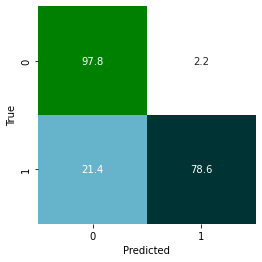

In [29]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = mv_clf.predict(X_test)
plotCM(y_test,y_pred, normalize=True)

In [30]:
print(classification_report(y_test,y_pred)) #Medidas de desempeño para el casificador multiclase por mayoría de votos

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     13225
           1       0.84      0.79      0.81      1896

    accuracy                           0.95     15121
   macro avg       0.90      0.88      0.89     15121
weighted avg       0.95      0.95      0.95     15121



A continuación, realizamos una comparación con el clasificador de mayoría de votos de sklearn:

In [31]:
#Importamos el VotingClssifier de sklearn para observar si los resultados mejoran
from sklearn.ensemble import VotingClassifier

In [32]:
#Definimos el max voting para los mismos clasificadores tratados en el numeral anterior
mv_skln=VotingClassifier(estimators=[('pipe1', pipe1), ('clf2', clf2), ('pipe3', pipe3)],voting='hard', weights=None)

In [33]:
#Ajustamos el clasificador a los conjuntos de entrenamiento y prueba
mv_skln=mv_skln.fit(X_train,y_train)

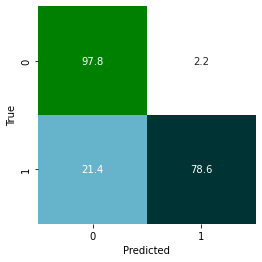

In [34]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = mv_skln.predict(X_test)
plotCM(y_test,y_pred, normalize=True)

In [35]:
print(classification_report(y_test,y_pred)) #Medidas de desempeño para el casificador multiclase por mayoría de votos

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     13225
           1       0.84      0.79      0.81      1896

    accuracy                           0.95     15121
   macro avg       0.90      0.88      0.89     15121
weighted avg       0.95      0.95      0.95     15121



Los resultados observados son iguales.

### Modelos de Ensemble para 3-lags, target Buy Local / Sell Externo

### Stacking

A continuación probamos un modelo de apliamiento con una instancia de un modelo de Random Forest, una instancia de un modelo de clasificación de soporte vectorial y un estimador final de regresión logística.

In [36]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

In [37]:
#Para este ejercicio utilizaremos un clasificador RandomForest, y un clasificador LinearSVC
estimators = [('rf', RandomForestClassifier(n_estimators=10, random_state=42)),('svr', make_pipeline(StandardScaler(),
                          SVC(C=1,kernel='rbf')))]

In [38]:
stk_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(multi_class='ovr',
                          solver='lbfgs',max_iter=500))

In [39]:
#Ajustamos el modelo con los conjuntos de entrenamiento
stk_clf=stk_clf.fit(X_train,y_train)

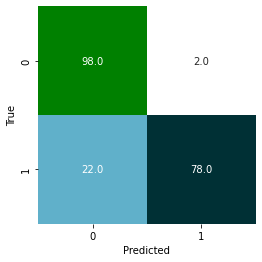

In [40]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = stk_clf.predict(X_test)
plotCM(y_test,y_pred, normalize=True)

In [41]:
print(classification_report(y_test,y_pred)) #Medidas de desempeño para el casificador multiclase por mayoría de votos

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     13225
           1       0.85      0.78      0.81      1896

    accuracy                           0.95     15121
   macro avg       0.91      0.88      0.89     15121
weighted avg       0.95      0.95      0.95     15121



Se observa un ligero incremento en la precisión para este clasificador.

### Bagging

A continuación probamos un ensemble tipo bagging con un árbol de decisión como clasificador base y 500 estimadores.

In [42]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=None,
                              random_state=1)

bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=1)

In [43]:
#Ajustamos el clasificador a los datos de entrenamiento.
bag=bag.fit(X_train,y_train)

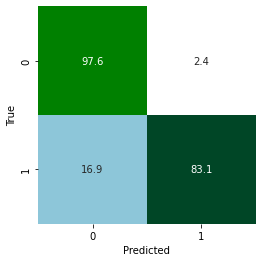

In [44]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = bag.predict(X_test)
plotCM(y_test,y_pred, normalize=True)

In [45]:
print(classification_report(y_test,y_pred)) #Medidas de desempeño para el casificador multiclase por mayoría de votos

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     13225
           1       0.83      0.83      0.83      1896

    accuracy                           0.96     15121
   macro avg       0.90      0.90      0.90     15121
weighted avg       0.96      0.96      0.96     15121



Observamos que, a pesar de que el clasificador base del ensemble es un clasificador muy simple, aplicando un bagging a un conjunto de 500 clasificadores base de este tipo, obtenemos un resultado superior términos de métricas de rendimiento, tanto con respecto al modelo base, como al modelo de stacking.
A continuación probamos un bagging con un clasificador base SVC. Aplicamos también un bootstrap a los features.

### Bagging con Bootstrap a los features

El proósito del ejercicio es observar el rendimiento del modelo, aplicando un bootstrap a los features. Para este caso, probamos con un clasificador de soporte vectorial como estimador base.

In [46]:
bag_svc = BaggingClassifier(base_estimator=SVC(C=1,kernel='rbf'),
                        n_estimators=30, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=True, 
                        n_jobs=1, 
                        random_state=0)

In [47]:
#Ajustamos el clasificador a los datos de entrenamiento.
bag_svc=bag_svc.fit(X_train,y_train)

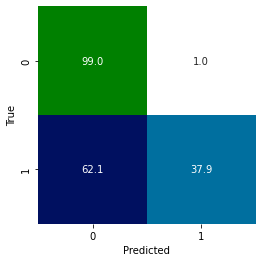

In [48]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = bag_svc.predict(X_test)
plotCM(y_test,y_pred, normalize=True)

In [49]:
print(classification_report(y_test,y_pred)) #Medidas de desempeño para el casificador 

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     13225
           1       0.85      0.38      0.52      1896

    accuracy                           0.91     15121
   macro avg       0.88      0.68      0.74     15121
weighted avg       0.91      0.91      0.90     15121



Observamos que al eliminar algunos lags aleatoriamente del conjunto de variables independiente, hay un efecto negativo sobre las métricas de rendimiento.

### Modelos de Boosting

### Adaptative Boosting

A continuación probamos con un modelo de boosting adaptativo, basado en una secuencia 500 árboles de decisión secuenciados, de tal manera que la secuencia de árboles trata de corregir el error en la clasificación en cada paso de la secuencia.

In [50]:
from sklearn.ensemble import AdaBoostClassifier


tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1,
                              random_state=1)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=1)

In [51]:
#Ajustamos el clasificador a los datos de entrenamiento
ada=ada.fit(X_train,y_train)

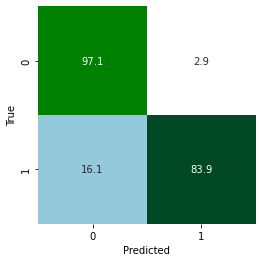

In [52]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = ada.predict(X_test)
plotCM(y_test,y_pred, normalize=True)

In [53]:
print(classification_report(y_test,y_pred)) #Medidas de desempeño para el casificador multiclase 

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     13225
           1       0.81      0.84      0.82      1896

    accuracy                           0.95     15121
   macro avg       0.89      0.90      0.90     15121
weighted avg       0.96      0.95      0.95     15121



### Gradient Boosting

In [54]:
#Primero ajustamos un modelo XGBClassifier con 1000 estimadores y profundidad máxima de 4
model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.01, max_depth=4, random_state=1, use_label_encoder=False)

In [55]:
gbm = model.fit(X_train, y_train)

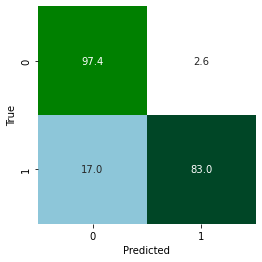

In [56]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = gbm.predict(X_test)
plotCM(y_test,y_pred, normalize=True)

In [57]:
print(classification_report(y_test,y_pred)) #Medidas de desempeño para el casificador multiclase 

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     13225
           1       0.82      0.83      0.83      1896

    accuracy                           0.96     15121
   macro avg       0.90      0.90      0.90     15121
weighted avg       0.96      0.96      0.96     15121



### Modelos de última generación

### Histogram Boost Gradient

In [58]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [59]:
#Ajustamos el modelo para los conjuntos de entrenamiento
clf_histBC = HistGradientBoostingClassifier().fit(X_train, y_train)

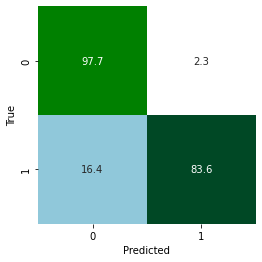

In [60]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = clf_histBC.predict(X_test)
plotCM(y_test,y_pred, normalize=True)

In [61]:
print(classification_report(y_test,y_pred)) #Medidas de desempeño para el casificador multiclase 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     13225
           1       0.84      0.84      0.84      1896

    accuracy                           0.96     15121
   macro avg       0.91      0.91      0.91     15121
weighted avg       0.96      0.96      0.96     15121



### LightGBM

In [62]:
import lightgbm as lgb

In [63]:
gbm = lgb.LGBMClassifier(num_leaves=31,
                        learning_rate=0.5,
                        n_estimators=20)

In [64]:
#Ajustamos el modelo con los conjuntos de entrenamiento
gbm=gbm.fit(X_train, y_train)

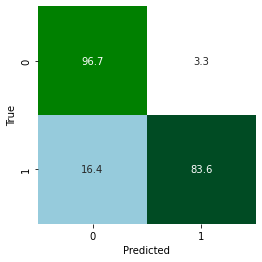

In [65]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = gbm.predict(X_test,num_iteration=gbm.best_iteration_)
plotCM(y_test,y_pred, normalize=True)

In [66]:
print(classification_report(y_test,y_pred)) #Medidas de desempeño para el casificador multiclase 

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     13225
           1       0.79      0.84      0.81      1896

    accuracy                           0.95     15121
   macro avg       0.88      0.90      0.89     15121
weighted avg       0.95      0.95      0.95     15121



### CatBoost

In [67]:
from catboost import CatBoostClassifier

In [68]:
model = CatBoostClassifier(iterations=40,
                           depth=6,
                           learning_rate=1,
                           #loss_function='Logloss',
                           verbose=True)

In [69]:
#Ajustamos el modelo con los conjuntos de entrenamiento
cat=model.fit(X_train, y_train)

0:	learn: 0.1399620	total: 92.4ms	remaining: 3.6s
1:	learn: 0.1320706	total: 115ms	remaining: 2.18s
2:	learn: 0.1257071	total: 141ms	remaining: 1.74s
3:	learn: 0.1201592	total: 164ms	remaining: 1.48s
4:	learn: 0.1175771	total: 188ms	remaining: 1.31s
5:	learn: 0.1162792	total: 212ms	remaining: 1.2s
6:	learn: 0.1140256	total: 237ms	remaining: 1.12s
7:	learn: 0.1127216	total: 262ms	remaining: 1.05s
8:	learn: 0.1113819	total: 286ms	remaining: 984ms
9:	learn: 0.1103940	total: 316ms	remaining: 948ms
10:	learn: 0.1091606	total: 349ms	remaining: 920ms
11:	learn: 0.1073722	total: 391ms	remaining: 913ms
12:	learn: 0.1061690	total: 439ms	remaining: 911ms
13:	learn: 0.1047934	total: 483ms	remaining: 896ms
14:	learn: 0.1037156	total: 523ms	remaining: 871ms
15:	learn: 0.1029985	total: 581ms	remaining: 871ms
16:	learn: 0.1021023	total: 622ms	remaining: 841ms
17:	learn: 0.1009954	total: 670ms	remaining: 819ms
18:	learn: 0.0997947	total: 715ms	remaining: 791ms
19:	learn: 0.0985924	total: 756ms	remainin

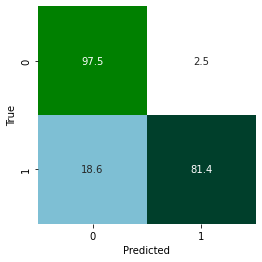

In [70]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = cat.predict(X_test)
plotCM(y_test,y_pred, normalize=True)

In [71]:
print(classification_report(y_test,y_pred)) #Medidas de desempeño para el casificador multiclase 

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     13225
           1       0.83      0.81      0.82      1896

    accuracy                           0.96     15121
   macro avg       0.90      0.89      0.90     15121
weighted avg       0.95      0.96      0.95     15121



### Modelos para 3-lags, target Buy Externo / Sell Local

A continuación evaluamos los mismos modelos de clasificación, no obstante el target esta vez será la categoría de arbitraje para condiciones de compra en el exterior, venta local.

In [72]:
# Esta vez, realizamos un train test split pero estratificado con respecto a un nuevo target.
X_train, X_test, y_train, y_test = train_test_split(X_std, y_BE_SL, test_size=0.3, random_state=0, stratify=y_BE_SL)

### Modelo Base

In [73]:
clf1 = LogisticRegression(multi_class='ovr',
                          solver='lbfgs',
                         max_iter=500)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=5,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels): #[pipe1, clf2, pipe3]
    scores = cross_validate(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring=('accuracy','precision_macro', 'recall_macro', 'f1_macro'))
    print(f'Modelo: {label}')
  
    print(f'Accuracy: {scores.get("test_accuracy").mean():.2f} '
          f'(+/- {scores.get("test_accuracy").std():.2f}) [{label}]');

    print(f'Precision: {scores.get("test_precision_macro").mean():.2f} '
          f'(+/- {scores.get("test_precision_macro").std():.2f}) [{label}]');

    print(f'Recall: {scores.get("test_recall_macro").mean():.2f} '
          f'(+/- {scores.get("test_recall_macro").std():.2f}) [{label}]');

    print(f'f1_score: {scores.get("test_f1_macro").mean():.2f} '
          f'(+/- {scores.get("test_f1_macro").std():.2f}) [{label}]');

10-fold cross validation:

Modelo: Logistic regression
Accuracy: 0.95 (+/- 0.00) [Logistic regression]
Precision: 0.88 (+/- 0.02) [Logistic regression]
Recall: 0.62 (+/- 0.01) [Logistic regression]
f1_score: 0.68 (+/- 0.02) [Logistic regression]
Modelo: Decision tree
Accuracy: 0.96 (+/- 0.00) [Decision tree]
Precision: 0.80 (+/- 0.01) [Decision tree]
Recall: 0.89 (+/- 0.01) [Decision tree]
f1_score: 0.84 (+/- 0.01) [Decision tree]
Modelo: KNN
Accuracy: 0.97 (+/- 0.00) [KNN]
Precision: 0.89 (+/- 0.01) [KNN]
Recall: 0.86 (+/- 0.01) [KNN]
f1_score: 0.87 (+/- 0.01) [KNN]


In [74]:
# Majority Rule (hard) Voting

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_validate(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring=('accuracy','precision_macro', 'recall_macro', 'f1_macro'))
    print(f'Modelo: {label}')
  
    print(f'Accuracy: {scores.get("test_accuracy").mean():.2f} '
          f'(+/- {scores.get("test_accuracy").std():.2f}) [{label}]');

    print(f'Precision: {scores.get("test_precision_macro").mean():.2f} '
          f'(+/- {scores.get("test_precision_macro").std():.2f}) [{label}]');

    print(f'Recall: {scores.get("test_recall_macro").mean():.2f} '
          f'(+/- {scores.get("test_recall_macro").std():.2f}) [{label}]');

    print(f'f1_score: {scores.get("test_f1_macro").mean():.2f} '
          f'(+/- {scores.get("test_f1_macro").std():.2f}) [{label}]');

Modelo: Logistic regression
Accuracy: 0.95 (+/- 0.00) [Logistic regression]
Precision: 0.88 (+/- 0.02) [Logistic regression]
Recall: 0.62 (+/- 0.01) [Logistic regression]
f1_score: 0.68 (+/- 0.02) [Logistic regression]
Modelo: Decision tree
Accuracy: 0.96 (+/- 0.00) [Decision tree]
Precision: 0.80 (+/- 0.01) [Decision tree]
Recall: 0.89 (+/- 0.01) [Decision tree]
f1_score: 0.84 (+/- 0.01) [Decision tree]
Modelo: KNN
Accuracy: 0.97 (+/- 0.00) [KNN]
Precision: 0.89 (+/- 0.01) [KNN]
Recall: 0.86 (+/- 0.01) [KNN]
f1_score: 0.87 (+/- 0.01) [KNN]
Modelo: Majority voting
Accuracy: 0.97 (+/- 0.00) [Majority voting]
Precision: 0.90 (+/- 0.02) [Majority voting]
Recall: 0.82 (+/- 0.02) [Majority voting]
f1_score: 0.85 (+/- 0.02) [Majority voting]


### Visualización Resultados: Modelo Base

In [75]:
#Ajustamos el clasificador de mayoría de votos con los conjuntos de entrenamiento
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3]).fit(X_train,y_train)

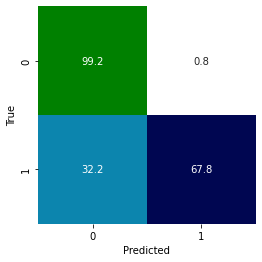

In [76]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = mv_clf.predict(X_test)
plotCM(y_test,y_pred, normalize=True)

In [77]:
print(classification_report(y_test,y_pred)) #Medidas de desempeño para el casificador multiclase por mayoría de votos

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     14177
           1       0.85      0.68      0.76       944

    accuracy                           0.97     15121
   macro avg       0.92      0.84      0.87     15121
weighted avg       0.97      0.97      0.97     15121



### Modelos de Ensemble para 3-lags, target Buy Externo / Sell Local

### Stacking

A continuación probamos un modelo de apliamiento con una instancia de un modelo de Random Forest, una instancia de un modelo de clasificación de soporte vectorial y un estimador final de regresión logística.

In [78]:
#Para este ejercicio utilizaremos un clasificador RandomForest, y un clasificador LinearSVC
estimators = [('rf', RandomForestClassifier(n_estimators=10, random_state=42)),('svr', make_pipeline(StandardScaler(),
                          SVC(C=1,kernel='rbf')))]

In [79]:
stk_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(multi_class='ovr',
                          solver='lbfgs',max_iter=500))

In [80]:
#Ajustamos el modelo con los conjuntos de entrenamiento
stk_clf=stk_clf.fit(X_train,y_train)

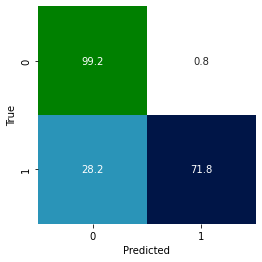

In [81]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = stk_clf.predict(X_test)
plotCM(y_test,y_pred, normalize=True)

In [82]:
print(classification_report(y_test,y_pred)) #Medidas de desempeño para el casificador multiclase por stacking

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     14177
           1       0.86      0.72      0.78       944

    accuracy                           0.98     15121
   macro avg       0.92      0.86      0.88     15121
weighted avg       0.97      0.98      0.97     15121



### Bagging

Probamos un modelo de ensemble tipo bagging con un árbol de decisón como estimador base y 500 estimadores. En primer lugar permitimos bootstrap para las observaciones pero no para los features. En segundo lugar, observamos el efecto de aplicar boostrap a los features.

In [83]:
tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=None,
                              random_state=1)

bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=1)

In [84]:
#Ajustamos el clasificador a los datos de entrenamiento.
bag=bag.fit(X_train,y_train)

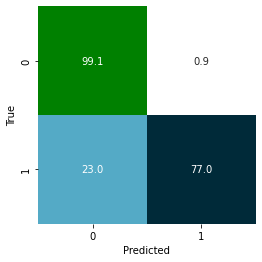

In [85]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = bag.predict(X_test)
plotCM(y_test,y_pred, normalize=True)

In [86]:
print(classification_report(y_test,y_pred)) #Medidas de desempeño para el casificador multiclase por bagging

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     14177
           1       0.85      0.77      0.81       944

    accuracy                           0.98     15121
   macro avg       0.92      0.88      0.90     15121
weighted avg       0.98      0.98      0.98     15121



### Bagging con bootstrap a los features

In [87]:
bag_svc = BaggingClassifier(base_estimator=SVC(C=1,kernel='rbf'),
                        n_estimators=30, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=True, 
                        n_jobs=1, 
                        random_state=0)

In [88]:
#Ajustamos el clasificador a los datos de entrenamiento.
bag_svc=bag_svc.fit(X_train,y_train)

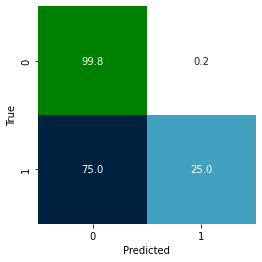

In [89]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = bag_svc.predict(X_test)
plotCM(y_test,y_pred, normalize=True)

In [90]:
print(classification_report(y_test,y_pred)) #Medidas de desempeño para el casificador multiclase por bagging

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     14177
           1       0.91      0.25      0.39       944

    accuracy                           0.95     15121
   macro avg       0.93      0.62      0.68     15121
weighted avg       0.95      0.95      0.94     15121



Observamos los mismos resultados con respecto al primer target: las métricas de clasificación disminuyen al eliminar aleatoriamente algunos features.

### Modelos de Boosting

### Adaptative Boosting

Tal como hicimos con la clasificación binaria previa, ajustamos un modelo de boosting adaptativo con una secuencia de 500 estimadores (áreboles de decisión).

In [91]:
tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1,
                              random_state=1)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=1)

In [92]:
#Ajustamos el clasificador a los datos de entrenamiento
ada=ada.fit(X_train,y_train)

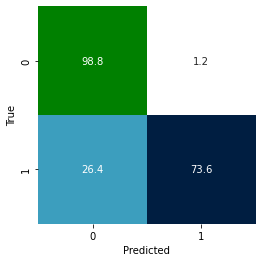

In [93]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = ada.predict(X_test)
plotCM(y_test,y_pred, normalize=True)

In [94]:
print(classification_report(y_test,y_pred)) #Medidas de desempeño para el casificador multiclase 

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     14177
           1       0.80      0.74      0.77       944

    accuracy                           0.97     15121
   macro avg       0.89      0.86      0.88     15121
weighted avg       0.97      0.97      0.97     15121



### Gradient Boosting

In [95]:
#Primero ajustamos un modelo XGBClassifier con 1000 estimadores y profundidad máxima de 4
model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.01, max_depth=4, random_state=1, use_label_encoder=False)

In [96]:
gbm = model.fit(X_train, y_train)

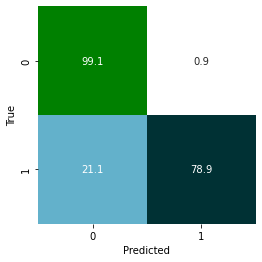

In [97]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = gbm.predict(X_test)
plotCM(y_test,y_pred, normalize=True)

In [98]:
print(classification_report(y_test,y_pred)) #Medidas de desempeño para el casificador multiclase 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     14177
           1       0.85      0.79      0.82       944

    accuracy                           0.98     15121
   macro avg       0.92      0.89      0.90     15121
weighted avg       0.98      0.98      0.98     15121



### Modelos de última generación

### Histogram Boost Gradient

In [99]:
#Ajustamos el modelo para los conjuntos de entrenamiento
clf_histBC = HistGradientBoostingClassifier().fit(X_train, y_train)

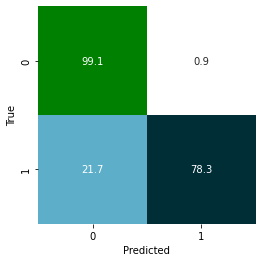

In [100]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = clf_histBC.predict(X_test)
plotCM(y_test,y_pred, normalize=True)

In [101]:
print(classification_report(y_test,y_pred)) #Medidas de desempeño para el casificador multiclase 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     14177
           1       0.85      0.78      0.81       944

    accuracy                           0.98     15121
   macro avg       0.92      0.89      0.90     15121
weighted avg       0.98      0.98      0.98     15121



### LightGBM

In [102]:
gbm = lgb.LGBMClassifier(num_leaves=31,
                        learning_rate=0.5,
                        n_estimators=20)

In [103]:
#Ajustamos el modelo con los conjuntos de entrenamiento
gbm=gbm.fit(X_train, y_train)

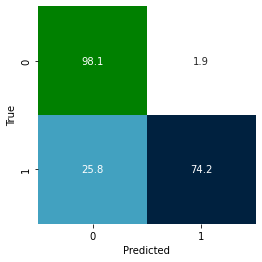

In [104]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = gbm.predict(X_test,num_iteration=gbm.best_iteration_)
plotCM(y_test,y_pred, normalize=True)

In [105]:
print(classification_report(y_test,y_pred)) #Medidas de desempeño para el casificador multiclase 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     14177
           1       0.72      0.74      0.73       944

    accuracy                           0.97     15121
   macro avg       0.85      0.86      0.86     15121
weighted avg       0.97      0.97      0.97     15121



### CatBoost

In [106]:
model = CatBoostClassifier(iterations=40,
                           depth=6,
                           learning_rate=1,
                           #loss_function='Logloss',
                           verbose=True)

In [107]:
#Ajustamos el modelo con los conjuntos de entrenamiento
cat=model.fit(X_train, y_train)

0:	learn: 0.1105025	total: 26.8ms	remaining: 1.04s
1:	learn: 0.0848660	total: 48.8ms	remaining: 928ms
2:	learn: 0.0779031	total: 74ms	remaining: 913ms
3:	learn: 0.0728393	total: 95.2ms	remaining: 857ms
4:	learn: 0.0712668	total: 117ms	remaining: 821ms
5:	learn: 0.0677310	total: 141ms	remaining: 799ms
6:	learn: 0.0669014	total: 163ms	remaining: 768ms
7:	learn: 0.0642289	total: 187ms	remaining: 748ms
8:	learn: 0.0626859	total: 208ms	remaining: 717ms
9:	learn: 0.0616967	total: 238ms	remaining: 715ms
10:	learn: 0.0603841	total: 267ms	remaining: 705ms
11:	learn: 0.0595559	total: 296ms	remaining: 691ms
12:	learn: 0.0585010	total: 336ms	remaining: 699ms
13:	learn: 0.0572586	total: 374ms	remaining: 694ms
14:	learn: 0.0565955	total: 405ms	remaining: 675ms
15:	learn: 0.0558581	total: 438ms	remaining: 658ms
16:	learn: 0.0545079	total: 492ms	remaining: 665ms
17:	learn: 0.0535074	total: 527ms	remaining: 645ms
18:	learn: 0.0527745	total: 575ms	remaining: 636ms
19:	learn: 0.0520972	total: 611ms	remai

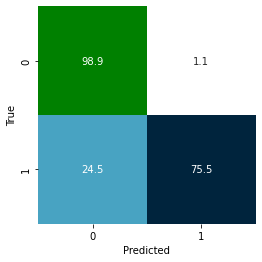

In [108]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = cat.predict(X_test)
plotCM(y_test,y_pred, normalize=True)

In [109]:
print(classification_report(y_test,y_pred)) #Medidas de desempeño para el casificador multiclase 

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     14177
           1       0.82      0.76      0.79       944

    accuracy                           0.97     15121
   macro avg       0.90      0.87      0.89     15121
weighted avg       0.97      0.97      0.97     15121



### Modelos para 3-lags: Arbitraje independiente de categoría

Realizamos un nuevo split para los obtener conjuntos de entrenamiento y prueba, pero esta vez observaremos el comportamiento de algunos de los modelos con un nuevo target: las condiciones de arbitraje independientes de la categoría. Esto nos dará una referencia sobre el promedio de arbitrajes correctamente clasificados (independientemente de si son BL/SE o BE/SL), aunque no tendrá valor práctico, pues el objetivo con valor práctico es obtener un modelo que además de identificar condiciones de arbitraje, informe qué tipo de arbitraje se presenta.

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y_arb, test_size=0.3, random_state=0, stratify=y_arb)

### Gradient Boosting

In [111]:
#Primero ajustamos un modelo XGBClassifier con 1000 estimadores y profundidad máxima de 4
model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.01, max_depth=4, random_state=1, use_label_encoder=False)

In [112]:
gbm = model.fit(X_train, y_train)

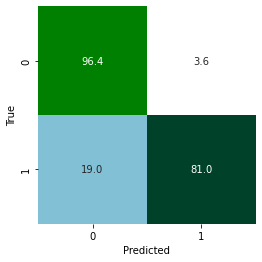

In [113]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = gbm.predict(X_test)
plotCM(y_test,y_pred, normalize=True)

In [114]:
print(classification_report(y_test,y_pred)) #Medidas de desempeño para el casificador multiclase 

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     12281
           1       0.84      0.81      0.82      2840

    accuracy                           0.93     15121
   macro avg       0.90      0.89      0.89     15121
weighted avg       0.93      0.93      0.93     15121



### Histogram Boost Gradient

In [115]:
#Ajustamos el modelo para los conjuntos de entrenamiento
clf_histBC = HistGradientBoostingClassifier().fit(X_train, y_train)

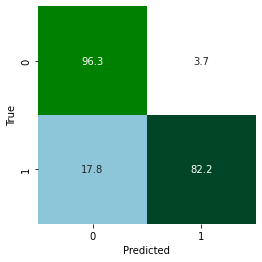

In [116]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = clf_histBC.predict(X_test)
plotCM(y_test,y_pred, normalize=True)

In [117]:
print(classification_report(y_test,y_pred)) #Medidas de desempeño para el casificador multiclase 

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     12281
           1       0.84      0.82      0.83      2840

    accuracy                           0.94     15121
   macro avg       0.90      0.89      0.90     15121
weighted avg       0.94      0.94      0.94     15121



### CatBoost

In [118]:
model = CatBoostClassifier(iterations=40,
                           depth=6,
                           learning_rate=1,
                           #loss_function='Logloss',
                           verbose=True)

In [119]:
#Ajustamos el modelo con los conjuntos de entrenamiento
cat=model.fit(X_train, y_train)

0:	learn: 0.2415227	total: 27.9ms	remaining: 1.09s
1:	learn: 0.2198576	total: 49.9ms	remaining: 947ms
2:	learn: 0.2047715	total: 71.4ms	remaining: 881ms
3:	learn: 0.1988282	total: 95.8ms	remaining: 862ms
4:	learn: 0.1926935	total: 118ms	remaining: 827ms
5:	learn: 0.1864058	total: 143ms	remaining: 808ms
6:	learn: 0.1819975	total: 168ms	remaining: 793ms
7:	learn: 0.1788519	total: 193ms	remaining: 773ms
8:	learn: 0.1774277	total: 215ms	remaining: 740ms
9:	learn: 0.1755461	total: 250ms	remaining: 751ms
10:	learn: 0.1739278	total: 285ms	remaining: 752ms
11:	learn: 0.1714172	total: 314ms	remaining: 732ms
12:	learn: 0.1693366	total: 353ms	remaining: 734ms
13:	learn: 0.1677149	total: 396ms	remaining: 735ms
14:	learn: 0.1659354	total: 430ms	remaining: 717ms
15:	learn: 0.1647011	total: 473ms	remaining: 710ms
16:	learn: 0.1638595	total: 513ms	remaining: 694ms
17:	learn: 0.1619836	total: 554ms	remaining: 677ms
18:	learn: 0.1604261	total: 590ms	remaining: 653ms
19:	learn: 0.1597718	total: 629ms	rem

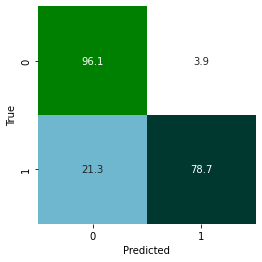

In [120]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = cat.predict(X_test)
plotCM(y_test,y_pred, normalize=True)

In [121]:
print(classification_report(y_test,y_pred)) #Medidas de desempeño para el casificador multiclase 

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     12281
           1       0.82      0.79      0.81      2840

    accuracy                           0.93     15121
   macro avg       0.89      0.87      0.88     15121
weighted avg       0.93      0.93      0.93     15121



### Modelos con 3-lags que identifican la categoría de Arbitraje

Para esta parte del ejercicio, realizaremos una clasificación multiclase. Además de identificar si se presentan condiciones de arbitraje, el modelo debería identificar qué tipo de arbitraje se obtione (BL/SE o BE/SL). Para esta sección, seleccionamos los modelos con los mejores resultados en las pruebas anteriores.

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y_cat, test_size=0.3, random_state=0,stratify=y_cat)

### Gradient Boostng

In [123]:
#Primero ajustamos un modelo XGBClassifier con 1000 estimadores y profundidad máxima de 4
model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.01, max_depth=4, random_state=1, use_label_encoder=False)

In [124]:
gbm = model.fit(X_train, y_train)

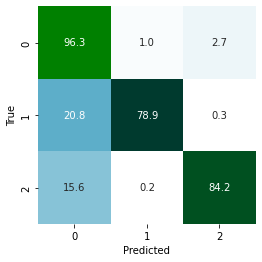

In [125]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = gbm.predict(X_test)
plotCM(y_test,y_pred, normalize=True)

In [126]:
print(classification_report(y_test,y_pred)) #Medidas de desempeño para el casificador multiclase 

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     12281
           1       0.85      0.79      0.82       944
           2       0.83      0.84      0.84      1896

    accuracy                           0.94     15121
   macro avg       0.88      0.86      0.87     15121
weighted avg       0.94      0.94      0.94     15121



### Histogram Boost Gradient

In [127]:
#Ajustamos el modelo para los conjuntos de entrenamiento
clf_histBC = HistGradientBoostingClassifier().fit(X_train, y_train)

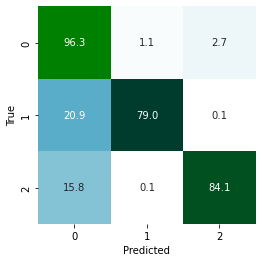

In [128]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = clf_histBC.predict(X_test)
plotCM(y_test,y_pred, normalize=True)

In [129]:
print(classification_report(y_test,y_pred)) #Medidas de desempeño para el casificador multiclase 

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     12281
           1       0.85      0.79      0.82       944
           2       0.83      0.84      0.84      1896

    accuracy                           0.94     15121
   macro avg       0.88      0.86      0.87     15121
weighted avg       0.94      0.94      0.94     15121



### CatBoost

In [130]:
model = CatBoostClassifier(iterations=40,
                           depth=6,
                           learning_rate=1,
                           #loss_function='Logloss',
                           verbose=True)

In [131]:
#Ajustamos el modelo con los conjuntos de entrenamiento
cat=model.fit(X_train, y_train)

0:	learn: 0.3162786	total: 66.3ms	remaining: 2.58s
1:	learn: 0.2600372	total: 111ms	remaining: 2.12s
2:	learn: 0.2508038	total: 157ms	remaining: 1.94s
3:	learn: 0.2314098	total: 210ms	remaining: 1.89s
4:	learn: 0.2210327	total: 301ms	remaining: 2.11s
5:	learn: 0.2137480	total: 601ms	remaining: 3.41s
6:	learn: 0.2085864	total: 848ms	remaining: 4s
7:	learn: 0.2065642	total: 982ms	remaining: 3.93s
8:	learn: 0.2037174	total: 1.14s	remaining: 3.92s
9:	learn: 0.1911737	total: 1.34s	remaining: 4.02s
10:	learn: 0.1880875	total: 1.54s	remaining: 4.07s
11:	learn: 0.1839562	total: 1.82s	remaining: 4.25s
12:	learn: 0.1821001	total: 2s	remaining: 4.16s
13:	learn: 0.1795603	total: 2.09s	remaining: 3.88s
14:	learn: 0.1778430	total: 2.17s	remaining: 3.62s
15:	learn: 0.1767445	total: 2.29s	remaining: 3.44s
16:	learn: 0.1759815	total: 2.38s	remaining: 3.23s
17:	learn: 0.1752784	total: 2.47s	remaining: 3.02s
18:	learn: 0.1741320	total: 2.57s	remaining: 2.84s
19:	learn: 0.1731541	total: 2.66s	remaining: 2

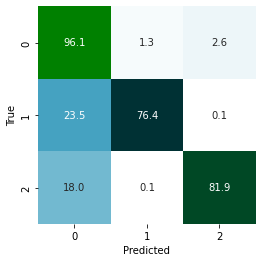

In [132]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = cat.predict(X_test)
plotCM(y_test,y_pred, normalize=True)

In [133]:
print(classification_report(y_test,y_pred)) #Medidas de desempeño para el casificador multiclase 

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     12281
           1       0.81      0.76      0.79       944
           2       0.83      0.82      0.82      1896

    accuracy                           0.93     15121
   macro avg       0.87      0.85      0.86     15121
weighted avg       0.93      0.93      0.93     15121



### Modelos con 5 y 10 lags

Con el objetivo de contrastar los resultados obtenidos para los modelos aplicados a la base de 3 lags, ajustamos el set de los clasificadores con mejores resultados a dos bases diferentes: una con 5-lags y otra con 10 lags de precios. Esto nos permitirá observar de alguna forma si la memoria de la serie de precios tiene incidencia en los resultados para la predicción de las condiciones de arbitraje. 

In [134]:
lags_5.head()

,Unnamed: 0,Date,Hora_COL,Minuto,Hora_NY,Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_ABIERTO,...,lag_1_Spread_BE_SL,lag_2_Spread_BE_SL,lag_3_Spread_BE_SL,lag_4_Spread_BE_SL,lag_5_Spread_BE_SL,lag_1_Spread_BL_SE,lag_2_Spread_BL_SE,lag_3_Spread_BL_SE,lag_4_Spread_BL_SE,lag_5_Spread_BL_SE
5,5,2022-01-03,9,59,9,False,False,0,0,1,...,-77.62100,-77.62100,-85.5630,-75.37175,-352.32380,-122.9355,-137.60644,-137.60644,-157.96754,-186.30125
6,6,2022-01-03,10,0,10,False,False,0,0,1,...,-69.28190,-77.62100,-77.6210,-85.56300,-75.37175,-122.9355,-122.93550,-137.60644,-137.60644,-157.96754
7,7,2022-01-03,10,1,10,False,False,0,0,1,...,-61.73700,-69.28190,-77.6210,-77.62100,-85.56300,-94.0900,-122.93550,-122.93550,-137.60644,-137.60644
8,8,2022-01-03,10,2,10,False,False,0,0,1,...,-237.10425,-61.73700,-69.2819,-77.62100,-77.62100,-12.8650,-94.09000,-122.93550,-122.93550,-137.60644
9,9,2022-01-03,10,3,10,False,False,0,0,1,...,-258.03170,-237.10425,-61.7370,-69.28190,-77.62100,-25.2895,-12.86500,-94.09000,-122.93550,-122.93550


In [135]:
lags_5.columns

Index(['Unnamed: 0', 'Date', 'Hora_COL', 'Minuto', 'Hora_NY', 'Festivo_COL',
       'Festivo_NYSE', 'Next_Day', 'Subasta', 'PFB_ABIERTO', 'CIB_ABIERTO',
       'CIB_close', 'COP_close', 'PFB_close', 'SPX_close', 'tasa_cambio',
       'USD_BID', 'USD_ASK', 'ASK_CIB', 'BID_CIB', 'ASK_PFB', 'BID_PFB',
       'Spread_BE_SL', 'Spread_BL_SE', 'Arbitraje_BE_SL', 'Arbitraje_BL_SE',
       'lag_1_CIB_close', 'lag_2_CIB_close', 'lag_3_CIB_close',
       'lag_4_CIB_close', 'lag_5_CIB_close', 'lag_1_COP_close',
       'lag_2_COP_close', 'lag_3_COP_close', 'lag_4_COP_close',
       'lag_5_COP_close', 'lag_1_PFB_close', 'lag_2_PFB_close',
       'lag_3_PFB_close', 'lag_4_PFB_close', 'lag_5_PFB_close',
       'lag_1_SPX_close', 'lag_2_SPX_close', 'lag_3_SPX_close',
       'lag_4_SPX_close', 'lag_5_SPX_close', 'lag_1_tasa_cambio',
       'lag_2_tasa_cambio', 'lag_3_tasa_cambio', 'lag_4_tasa_cambio',
       'lag_5_tasa_cambio', 'lag_1_USD_BID', 'lag_2_USD_BID', 'lag_3_USD_BID',
       'lag_4_USD_BID', 

### Modelos para 5 lags

Definimos el conjunto de features como los 5 últimos lags de precio para las variables numéricas de precio.

In [136]:
X=lags_5[['lag_1_CIB_close', 'lag_2_CIB_close', 'lag_3_CIB_close',
       'lag_4_CIB_close', 'lag_5_CIB_close', 'lag_1_COP_close',
       'lag_2_COP_close', 'lag_3_COP_close', 'lag_4_COP_close',
       'lag_5_COP_close', 'lag_1_PFB_close', 'lag_2_PFB_close', 'lag_3_PFB_close',
       'lag_4_PFB_close', 'lag_5_PFB_close', 'lag_1_SPX_close',
       'lag_2_SPX_close', 'lag_3_SPX_close', 'lag_4_SPX_close',
       'lag_5_SPX_close', 'lag_1_tasa_cambio', 'lag_2_tasa_cambio',
       'lag_3_tasa_cambio', 'lag_4_tasa_cambio', 'lag_5_tasa_cambio',
       'lag_1_USD_BID', 'lag_2_USD_BID', 'lag_3_USD_BID', 'lag_4_USD_BID',
       'lag_5_USD_BID', 'lag_1_USD_ASK', 'lag_2_USD_ASK', 'lag_3_USD_ASK',
       'lag_4_USD_ASK', 'lag_5_USD_ASK', 'lag_1_ASK_CIB', 'lag_2_ASK_CIB',
       'lag_3_ASK_CIB', 'lag_4_ASK_CIB', 'lag_5_ASK_CIB', 'lag_1_BID_CIB',
       'lag_2_BID_CIB', 'lag_3_BID_CIB', 'lag_4_BID_CIB', 'lag_5_BID_CIB',
       'lag_1_ASK_PFB', 'lag_2_ASK_PFB', 'lag_3_ASK_PFB', 'lag_4_ASK_PFB',
       'lag_5_ASK_PFB', 'lag_1_BID_PFB', 'lag_2_BID_PFB', 'lag_3_BID_PFB',
       'lag_4_BID_PFB', 'lag_5_BID_PFB', 'lag_1_Spread_BE_SL',
       'lag_2_Spread_BE_SL', 'lag_3_Spread_BE_SL', 'lag_4_Spread_BE_SL',
       'lag_5_Spread_BE_SL', 'lag_1_Spread_BL_SE', 'lag_2_Spread_BL_SE',
       'lag_3_Spread_BL_SE', 'lag_4_Spread_BL_SE', 'lag_5_Spread_BL_SE']]

In [137]:
X.head()

,lag_1_CIB_close,lag_2_CIB_close,lag_3_CIB_close,lag_4_CIB_close,lag_5_CIB_close,lag_1_COP_close,lag_2_COP_close,lag_3_COP_close,lag_4_COP_close,lag_5_COP_close,...,lag_1_Spread_BE_SL,lag_2_Spread_BE_SL,lag_3_Spread_BE_SL,lag_4_Spread_BE_SL,lag_5_Spread_BE_SL,lag_1_Spread_BL_SE,lag_2_Spread_BL_SE,lag_3_Spread_BL_SE,lag_4_Spread_BL_SE,lag_5_Spread_BL_SE
5,31.68,31.73,31.6697,31.5800,31.5800,4072.72,4073.86,4075.00,4075.00,4075.00,...,-77.62100,-77.62100,-85.5630,-75.37175,-352.32380,-122.9355,-137.60644,-137.60644,-157.96754,-186.30125
6,31.68,31.68,31.7300,31.6697,31.5800,4072.00,4072.72,4073.86,4075.00,4075.00,...,-69.28190,-77.62100,-77.6210,-85.56300,-75.37175,-122.9355,-122.93550,-137.60644,-137.60644,-157.96754
7,31.62,31.68,31.6800,31.7300,31.6697,4072.00,4072.00,4072.72,4073.86,4075.00,...,-61.73700,-69.28190,-77.6210,-77.62100,-85.56300,-94.0900,-122.93550,-122.93550,-137.60644,-137.60644
8,31.73,31.62,31.6800,31.6800,31.7300,4070.50,4072.00,4072.00,4072.72,4073.86,...,-237.10425,-61.73700,-69.2819,-77.62100,-77.62100,-12.8650,-94.09000,-122.93550,-122.93550,-137.60644
9,31.72,31.73,31.6200,31.6800,31.6800,4071.50,4070.50,4072.00,4072.00,4072.72,...,-258.03170,-237.10425,-61.7370,-69.28190,-77.62100,-25.2895,-12.86500,-94.09000,-122.93550,-122.93550


In [138]:
len(X)

50401

### Targets

Tal como hicimos para la base de 3-lags, definimos tres tipos de targets que representan las condiciones de arbitraje en el momento original.

In [139]:
y_BL_SE=lags_5['Arbitraje_BL_SE']
y_BE_SL=lags_5['Arbitraje_BE_SL']

In [140]:
y_arb=[]
for i in range(len(X)):
    if (y_BE_SL.loc[i+5]==1 or y_BL_SE.loc[i+5]==1):
        y_arb.append(1)
    else:
        y_arb.append(0)

In [141]:
y_cat=[]
for i in range(len(X)):
    if y_BE_SL.loc[i+5]==1: 
        y_cat.append(1)
    elif y_BL_SE.loc[i+5]==1:
        y_cat.append(2)
    else:
        y_cat.append(0)

### Modelos para 5-lags: Categoría Buy Local / Sell Externo

In [142]:
#Estandarizamos la base
X_std=StandardScaler().fit_transform(X)

In [143]:
#Train test split estratificado con el target de interés
X_train, X_test, y_train, y_test = train_test_split(X_std, y_BL_SE, test_size=0.3, random_state=0, stratify=y_BL_SE)

### Gradient Boosting

In [144]:
#Primero ajustamos un modelo XGBClassifier con 1000 estimadores y profundidad máxima de 4
model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.01, max_depth=4, random_state=1, use_label_encoder=False)

In [145]:
gbm = model.fit(X_train, y_train)

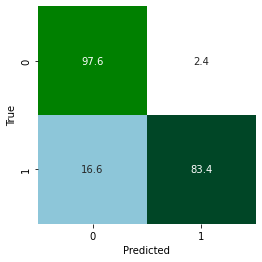

In [146]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = gbm.predict(X_test)
plotCM(y_test,y_pred, normalize=True)

In [147]:
print(classification_report(y_test,y_pred)) #Medidas de desempeño para el casificador multiclase 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     13225
           1       0.83      0.83      0.83      1896

    accuracy                           0.96     15121
   macro avg       0.90      0.90      0.90     15121
weighted avg       0.96      0.96      0.96     15121



### Histogram Gradient Boosting

In [148]:
#Ajustamos el modelo para los conjuntos de entrenamiento
clf_histBC = HistGradientBoostingClassifier().fit(X_train, y_train)

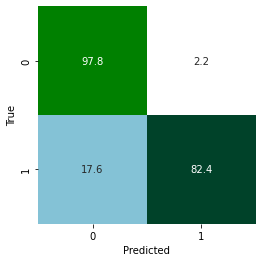

In [149]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = clf_histBC.predict(X_test)
plotCM(y_test,y_pred, normalize=True)

### LightGBM

In [150]:
gbm = lgb.LGBMClassifier(num_leaves=31,
                        learning_rate=0.5,
                        n_estimators=20)

In [151]:
#Ajustamos el modelo con los conjuntos de entrenamiento
gbm=gbm.fit(X_train, y_train)

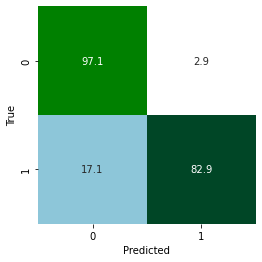

In [152]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = gbm.predict(X_test,num_iteration=gbm.best_iteration_)
plotCM(y_test,y_pred, normalize=True)

### Modelos para 5 lags que identifican la categoría de Arbitraje

In [153]:
#Estratiticamos el split con respecto al target multiclase
X_train, X_test, y_train, y_test = train_test_split(X_std, y_cat, test_size=0.3, random_state=0, stratify=y_cat)

### Gradient Boosting

In [154]:
gbm = model.fit(X_train, y_train)

[11:07:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




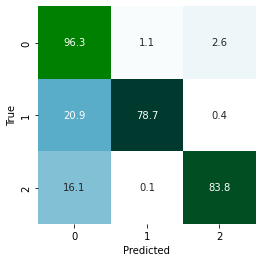

In [155]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = gbm.predict(X_test)
plotCM(y_test,y_pred, normalize=True)

### Modelo para 5-lags para identificar arbitraje independiente de la categoría

Tal como hicimos para 3-lags, vale la pena observar el promedio de arbitrajes correctamente clasificados, independientemente de si el modelo identifica la categoría de arbitraje (BE/SL o BL/SE). Esto nos permite tener un punto de referencia con el propósito de observar de manera general si la memoria del modelo tiene que ver con su capacidad para identificar condiciones de arbitraje.

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y_arb, test_size=0.3, random_state=0, stratify=y_arb)

In [157]:
#Ajustamos el modelo para los conjuntos de entrenamiento
clf_histBC = HistGradientBoostingClassifier().fit(X_train, y_train)

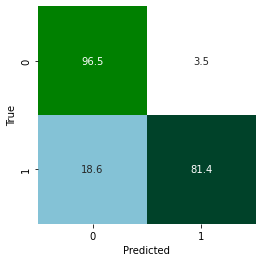

In [158]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = clf_histBC.predict(X_test)
plotCM(y_test,y_pred, normalize=True)

In [159]:
print(classification_report(y_test,y_pred)) #Medidas de desempeño para el casificador multiclase 

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     12281
           1       0.84      0.81      0.83      2840

    accuracy                           0.94     15121
   macro avg       0.90      0.89      0.89     15121
weighted avg       0.94      0.94      0.94     15121



Con respecto al mismo modelo aplciado a la base de 3-lags observamos una ligera disminución en las métricas de desempeño. Esta pequeña diferencia no nos permite establecer con evidencia suficiente cuál es la incidencia del número de rezagos en la capacidad predictiva del modelo para las condiciones de arbitraje, pero nos conduce a establecer un punto de partida para una metodología más formal y nos sugiere que debemos evaluar este punto más adelante.

### Modelos para 5-lags con variables categóricas y booleanas

En este punto del ejercicio, quisiéramos observar si el resultado de las predicciones al incluir en los features a las variables ordinales y categóricas, es mejor a los resultados obtenidos hasta el momento. Hacemos el ejercicio para la base de 5-lags con uno de los modelos que produjo los mejores resultados en las secciones anteriores.

In [160]:
#Variables ordinales, boolleanas y numéricas
X=lags_5[['Hora_COL', 'Minuto', 'Hora_NY', 'Festivo_COL',
       'Festivo_NYSE', 'Next_Day', 'Subasta', 'PFB_ABIERTO', 'CIB_ABIERTO',
        'lag_1_CIB_close', 'lag_2_CIB_close', 'lag_3_CIB_close',
       'lag_4_CIB_close', 'lag_5_CIB_close', 'lag_1_COP_close',
       'lag_2_COP_close', 'lag_3_COP_close', 'lag_4_COP_close',
       'lag_5_COP_close', 'lag_1_PFB_close', 'lag_2_PFB_close', 'lag_3_PFB_close',
       'lag_4_PFB_close', 'lag_5_PFB_close', 'lag_1_SPX_close',
       'lag_2_SPX_close', 'lag_3_SPX_close', 'lag_4_SPX_close',
       'lag_5_SPX_close', 'lag_1_tasa_cambio', 'lag_2_tasa_cambio',
       'lag_3_tasa_cambio', 'lag_4_tasa_cambio', 'lag_5_tasa_cambio',
       'lag_1_USD_BID', 'lag_2_USD_BID', 'lag_3_USD_BID', 'lag_4_USD_BID',
       'lag_5_USD_BID', 'lag_1_USD_ASK', 'lag_2_USD_ASK', 'lag_3_USD_ASK',
       'lag_4_USD_ASK', 'lag_5_USD_ASK', 'lag_1_ASK_CIB', 'lag_2_ASK_CIB',
       'lag_3_ASK_CIB', 'lag_4_ASK_CIB', 'lag_5_ASK_CIB', 'lag_1_BID_CIB',
       'lag_2_BID_CIB', 'lag_3_BID_CIB', 'lag_4_BID_CIB', 'lag_5_BID_CIB',
       'lag_1_ASK_PFB', 'lag_2_ASK_PFB', 'lag_3_ASK_PFB', 'lag_4_ASK_PFB',
       'lag_5_ASK_PFB', 'lag_1_BID_PFB', 'lag_2_BID_PFB', 'lag_3_BID_PFB',
       'lag_4_BID_PFB', 'lag_5_BID_PFB', 'lag_1_Spread_BE_SL',
       'lag_2_Spread_BE_SL', 'lag_3_Spread_BE_SL', 'lag_4_Spread_BE_SL',
       'lag_5_Spread_BE_SL', 'lag_1_Spread_BL_SE', 'lag_2_Spread_BL_SE',
       'lag_3_Spread_BL_SE', 'lag_4_Spread_BL_SE', 'lag_5_Spread_BL_SE']]

In [161]:
X_std=StandardScaler().fit_transform(X)

In [162]:
#estratificamos el split con el target multiclase
X_train, X_test, y_train, y_test = train_test_split(X_std, y_cat, test_size=0.3, random_state=0, stratify=y_cat)

### Gradient Boosting

In [163]:
gbm = model.fit(X_train, y_train)

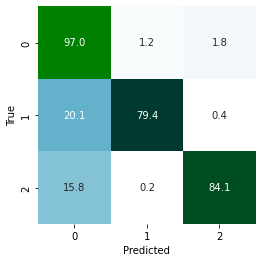

In [164]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = gbm.predict(X_test)
plotCM(y_test,y_pred, normalize=True)

In [165]:
print(classification_report(y_test,y_pred)) #Medidas de desempeño para el casificador multiclase 

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     12281
           1       0.84      0.79      0.82       944
           2       0.88      0.84      0.86      1896

    accuracy                           0.94     15121
   macro avg       0.89      0.87      0.88     15121
weighted avg       0.94      0.94      0.94     15121



Observamos, efectivamente, un ligero incremento en las métricas de desempeño con respecto al mismo modelo aplicado al set de variables estrictamente numéricas. Aunque no es evidencia para establecerlo, podemos partir de la base de que las variables ordinales y booleanas pueden generar un leve incremento en las métricas de desempeño.

### Selección de Features

Realizaremos el ejercicio con un modelo de selección de componentes principales con el propósito de observar si al aplicar una reducción de la dimensión por PCA, los resultados de los modelos se preservan o mejoran. 

In [166]:
#Componentes principales para una base con 5-lags
pca = PCA()
pca.fit_transform(X_std)

array([[ 1.08227642e+01, -1.92405337e+00, -4.20276333e-01, ...,
         4.19039417e-04,  2.06478116e-04,  2.15907265e-04],
       [ 1.07634260e+01, -1.84437217e+00, -4.56684993e-01, ...,
         3.80388729e-05,  5.76924361e-05, -1.09234701e-04],
       [ 1.07297564e+01, -1.85016536e+00, -4.51381535e-01, ...,
         3.44066940e-05,  1.59730885e-04,  1.02962054e-04],
       ...,
       [ 4.63061992e+00,  2.01250752e+00,  9.44122180e+00, ...,
         1.87652249e-04,  1.19673279e-04,  9.79866717e-05],
       [ 4.63508179e+00,  2.00977386e+00,  9.43057310e+00, ...,
        -1.56932862e-04,  1.15045589e-04, -7.13011460e-05],
       [ 4.63175020e+00,  2.00209183e+00,  9.40733279e+00, ...,
        -1.51323806e-04, -7.19839340e-05,  1.25358666e-04]])

In [167]:
#Varianza explicada para las componentes principales
pca.explained_variance_

array([3.55869063e+01, 1.43575361e+01, 8.35069923e+00, 4.26938771e+00,
       3.15540519e+00, 2.59985155e+00, 1.21124024e+00, 1.10129147e+00,
       1.02289085e+00, 8.85056266e-01, 7.42882205e-01, 2.00160610e-01,
       1.72416512e-01, 6.30088591e-02, 5.52611407e-02, 3.54701071e-02,
       2.95686952e-02, 2.92046623e-02, 2.70869694e-02, 2.49063660e-02,
       1.66833093e-02, 1.02518742e-02, 8.79104712e-03, 8.41867039e-03,
       7.06188218e-03, 5.01087549e-03, 3.95454898e-03, 3.41485107e-03,
       3.11328737e-03, 2.24493693e-03, 2.04929878e-03, 1.66860702e-03,
       1.64586979e-03, 1.28430908e-03, 7.83214367e-04, 7.59113855e-04,
       4.90924969e-04, 4.81492559e-04, 3.53227677e-04, 3.39709873e-04,
       2.71643191e-04, 2.46930149e-04, 2.10748692e-04, 1.97759942e-04,
       1.78180778e-04, 1.58913799e-04, 1.28606708e-04, 1.14545575e-04,
       1.06795326e-04, 9.00203201e-05, 7.61182448e-05, 7.27581867e-05,
       6.28382623e-05, 6.06998616e-05, 5.33923029e-05, 5.24494551e-05,
      

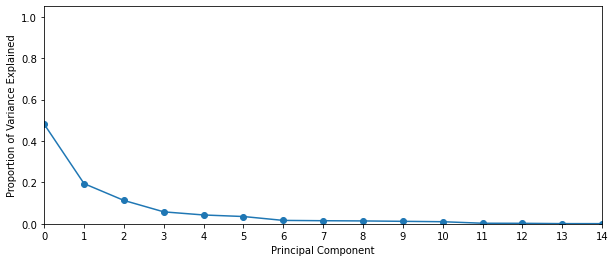

In [168]:
#Proporción de varianza explicada para las componentes principales
plt.figure(figsize=(10,4))
plt.plot(range(0,74), pca.explained_variance_ratio_, '-o')
plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks(range(0,15));

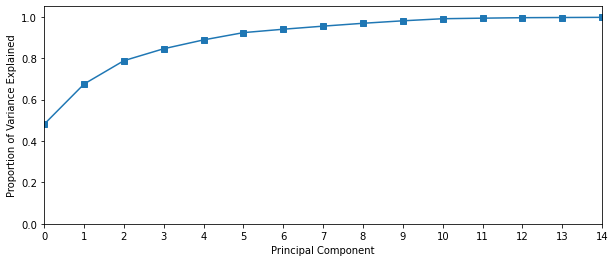

In [169]:
#Proporción de varianza explicada acumulada
plt.figure(figsize=(10,4))
plt.plot(range(0,74), np.cumsum(pca.explained_variance_ratio_), '-s')
plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks(range(0,15));

Observamos que las primeras siete componentes principales explican cerca del 90% de la varianza, por lo cual realizamos un pipe de clasificación con un modelo gradient boosting para las primeras siete componentes principales y observamos los resultados:

In [170]:
pipe1 = Pipeline([['pca', PCA(n_components=7)], ['clf', gbm]])

In [171]:
mod=pipe1.fit(X_train,y_train)

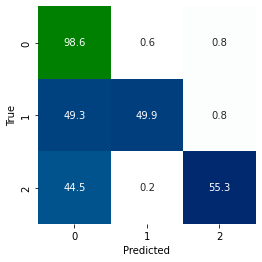

In [172]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = mod.predict(X_test)
plotCM(y_test,y_pred, normalize=True)

Observamos que el modelo pierde capacidad predictiva al aplicar un método de selección de features por PCA(). Esto puede obedeceder a que la estructura de la serie de tiempo se pierde cuando se realiza la selección.

In [173]:
print(classification_report(y_test,y_pred)) #Medidas de desempeño para el casificador multiclase 

              precision    recall  f1-score   support

           0       0.90      0.99      0.94     12281
           1       0.86      0.50      0.63       944
           2       0.91      0.55      0.69      1896

    accuracy                           0.90     15121
   macro avg       0.89      0.68      0.75     15121
weighted avg       0.90      0.90      0.89     15121



### Modelos para 10 Lags

Para contrastar los resultados obtenidos hasta ahora, repetimos el ejercicio con una base de diez lags, que cuenta con un número mayor de features: 

In [174]:
len(lags_10.columns)

156

In [175]:
#extraemos las columnas de variables categóricas y el estado de los precios actual.
columnas_fecha=['Date', 'Hora_COL', 'Minuto', 'Hora_NY', 'Festivo_COL', 'Festivo_NYSE', 'Next_Day', 'Subasta','PFB_ABIERTO',
'CIB_ABIERTO']
columnas_arb=['Arbitraje_BE_SL','Arbitraje_BL_SE']
sobrantes=columnas_fecha+columnas_precio+columnas_arb

In [176]:
#Construimos la base de 10 lags
X=lags_10.drop(sobrantes, axis=1)

In [177]:
#Verificamos la correcta selección de lags
for column in X.columns:
    print(column)

Unnamed: 0
lag_1_CIB_close
lag_2_CIB_close
lag_3_CIB_close
lag_4_CIB_close
lag_5_CIB_close
lag_6_CIB_close
lag_7_CIB_close
lag_8_CIB_close
lag_9_CIB_close
lag_10_CIB_close
lag_1_COP_close
lag_2_COP_close
lag_3_COP_close
lag_4_COP_close
lag_5_COP_close
lag_6_COP_close
lag_7_COP_close
lag_8_COP_close
lag_9_COP_close
lag_10_COP_close
lag_1_PFB_close
lag_2_PFB_close
lag_3_PFB_close
lag_4_PFB_close
lag_5_PFB_close
lag_6_PFB_close
lag_7_PFB_close
lag_8_PFB_close
lag_9_PFB_close
lag_10_PFB_close
lag_1_SPX_close
lag_2_SPX_close
lag_3_SPX_close
lag_4_SPX_close
lag_5_SPX_close
lag_6_SPX_close
lag_7_SPX_close
lag_8_SPX_close
lag_9_SPX_close
lag_10_SPX_close
lag_1_tasa_cambio
lag_2_tasa_cambio
lag_3_tasa_cambio
lag_4_tasa_cambio
lag_5_tasa_cambio
lag_6_tasa_cambio
lag_7_tasa_cambio
lag_8_tasa_cambio
lag_9_tasa_cambio
lag_10_tasa_cambio
lag_1_USD_BID
lag_2_USD_BID
lag_3_USD_BID
lag_4_USD_BID
lag_5_USD_BID
lag_6_USD_BID
lag_7_USD_BID
lag_8_USD_BID
lag_9_USD_BID
lag_10_USD_BID
lag_1_USD_ASK
lag_2_USD

In [178]:
#estandarizamos
X_std=StandardScaler().fit_transform(X)

### Targets

In [179]:
y_BL_SE=lags_10['Arbitraje_BL_SE']
y_BE_SL=lags_10['Arbitraje_BE_SL']

In [180]:
y_arb=[]
for i in range(len(X)):
    if (y_BE_SL.loc[i+10]==1 or y_BL_SE.loc[i+10]==1):
        y_arb.append(1)
    else:
        y_arb.append(0)

In [181]:
y_cat=[]
for i in range(len(X)):
    if y_BE_SL.loc[i+10]==1: 
        y_cat.append(1)
    elif y_BL_SE.loc[i+10]==1:
        y_cat.append(2)
    else:
        y_cat.append(0)

### Modelo para 10 lags para clasificación multiclase

In [182]:
#estratificamos con respecto a las tres categorías de arbitraje
X_train, X_test, y_train, y_test = train_test_split(X_std, y_cat, test_size=0.3, random_state=0, stratify=y_cat)

In [183]:
gbm = model.fit(X_train, y_train)

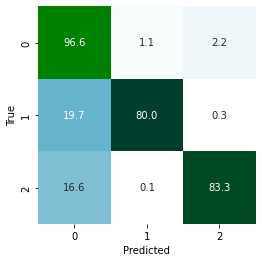

In [184]:
#Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
y_pred = gbm.predict(X_test)
plotCM(y_test,y_pred, normalize=True)

In [185]:
print(classification_report(y_test,y_pred)) #Medidas de desempeño para el casificador multiclase 

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     12279
           1       0.84      0.80      0.82       944
           2       0.85      0.83      0.84      1896

    accuracy                           0.94     15119
   macro avg       0.88      0.87      0.88     15119
weighted avg       0.94      0.94      0.94     15119

